#### Calculate wind shear according to LMI and their climatology

 - wind shear at LMI locations
 - Climatology (July-Sept) of wind shear at those locations
 - histogram plot of distributins comparison

from James'  get_era5_shear_at_lmi.ncl

Ming Ge June 2024

In [1]:
import os
import calendar
import glob
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from netCDF4 import Dataset

from tc_helping import hist_3, hist_4, latlon_ij, level_k

#### set up

In [2]:
lag = 2

#  averaging radius in degrees
rr = .5

year_s = 1990
year_e = 2020
n_year = year_e - year_s + 1

# climatology calculation only on July, Aug, Sept
months   = ['07', '08', '09']
last_day = ['31', '31', '30']
n_month = len(months)

# NA region:
lat_s = 5
lat_e = 60
lon_e = -10  
lon_s = -100

dir_plot = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/'

#### read in lmi times/locations

In [3]:
flnm = '/glade/work/done/tc_int/Kossin_LMIs_cut.csv'
df_all = pd.read_csv(flnm, delimiter=',', engine='python')

# for northern hemisphere, July, Aug. and Sept
df_lmi = df_all.loc[(df_all.klat.values >= lat_s) & (df_all.klat.values <= lat_e) &
                    (df_all.klon.values >= lon_s) & (df_all.klon.values <= lon_e) &
                    (df_all.kmon.values >=7) & (df_all.kmon.values<=9)]
print(df_lmi)
            
yyyy = df_lmi.kyear.values
mm   = df_lmi.kmon.values
dd   = df_lmi.kday.values
hh   = df_lmi.khour.values

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
yyyymmddhhs = [None] * ntim
for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)
    yyyy[nt] = datetime_lagged.year
    mm[nt]   = datetime_lagged.month
    dd[nt]   = datetime_lagged.day
    hh[nt]   = datetime_lagged.hour
    
    yyyy[nt] = str(yyyy[nt]) 
    mms[nt]  = str(mm[nt]).zfill(2)
    mms[nt]  = str(mm[nt]).zfill(2)
    dds[nt]  = str(dd[nt]).zfill(2)
    hhs[nt]  = str(hh[nt]).zfill(2)
    yyyymmddhh[nt] = int(yyyys[nt] + mms[nt] + dds[nt] + hhs[nt]) 
    yyyymmddhhs[nt] = str(yyyymmddhh[nt]) 

# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.klat.values*4.0, 0)/4.0
lon = df_lmi.klon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
vmax = df_lmi.lmi.values
#'lat:', lat.min(), '-', lat.max(), 'lon:',lon.min(), '-', lon.max()
#ntim

            ksid300  lmi  kyear  kmon  kday  khour   klat   klon
39    1979190N20290   35   1979     7     9     18  23.90 -71.00
40    1979191N22264   55   1979     7    11     12  29.25 -90.66
41    1979192N30280   45   1979     7    11      6  32.00 -75.90
43    1979197N13314   45   1979     7    21      0  20.45 -79.92
48    1979205N17325   35   1979     7    24     12  18.20 -42.10
...             ...  ...    ...   ...   ...    ...    ...    ...
4068  2017242N16333  145   2017     9     7      0  19.15 -65.94
4071  2017247N09327  110   2017     9     8     18  16.45 -57.64
4073  2017249N22263   80   2017     9     8     18  21.05 -96.15
4079  2017258N10337  100   2017     9    27      0  29.95 -55.04
4080  2017260N12310  140   2017     9    20      0  17.05 -64.14

[410 rows x 8 columns]


#### Calculate wind shear from ERA5

In [4]:
%%time
dir_era5 = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/'
flnm_csv = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_shear_NA.csv"
print('output', flnm_csv)

# identify K of level 850hPa and 200 hPa
flnm = dir_era5 + '197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc'
i_1d, j_1d = latlon_ij(lat, lon, flnm)
k850 = level_k (850, flnm)
k200 = level_k (200, flnm)

pattern_u = 'e5.oper.an.pl.128_131_u.ll025uv*nc'  
pattern_v = "e5.oper.an.pl.128_132_v.ll025uv*nc"

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    shear_lmi = df.shear
    print(shear_lmi)
else:
    shear = np.zeros((ntim))
    for nt in range(ntim):
        dir = dir_era5 + yyyys[nt] + mms[nt] + "/" 
        flnm_u = dir + "e5.oper.an.pl.128_131_u.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        print(nt, flnm_u)
        ncid = Dataset(flnm_u, mode='r')        
        U200 =  ncid.variables['U'][hh[nt], k200, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        U850 =  ncid.variables['U'][hh[nt], k850, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        ncid.close()
        
        flnm_v = dir + "e5.oper.an.pl.128_132_v.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        ncid = Dataset(flnm_v, mode='r')
        V200 =  ncid.variables['V'][hh[nt], k200, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        V850 =  ncid.variables['V'][hh[nt], k850, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        ncid.close()
         
        shear[nt] = (np.sqrt(np.square(U200-U850) + np.square(V200-V850))).mean()

    data = { 'yyyymmddhh': yyyymmddhhs, 'lat': lat, 'lon': lon, 'shear': shear}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False) 


output /glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_shear_NA.csv
/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
in /glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
in /glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_shear_NA.csv exist
0       6.022
1      21.395
2      20.567
3      13.479
4      16.575
        ...  
405    15.285
406    19.533
407    12.447
408     5.336
409    21.158
Name: shear, Length: 410, dtype: float64
CPU times: user 60.6 ms, sys: 11.2 ms, total: 71.8 ms
Wall time: 238 ms


#### 2 Calculate climatology

#### 3 histogram plot of distributins comparison

/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/shear_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


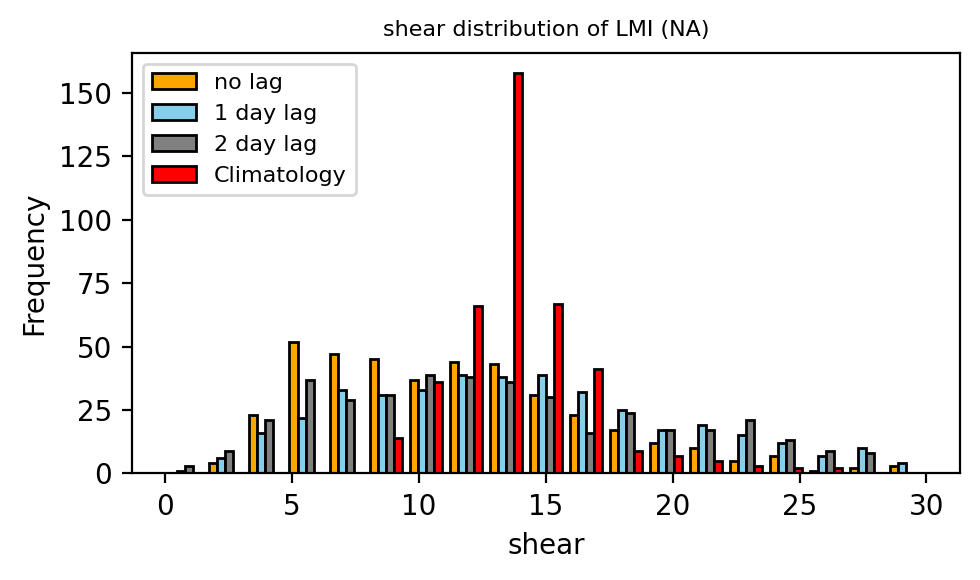

/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/shear_diff_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


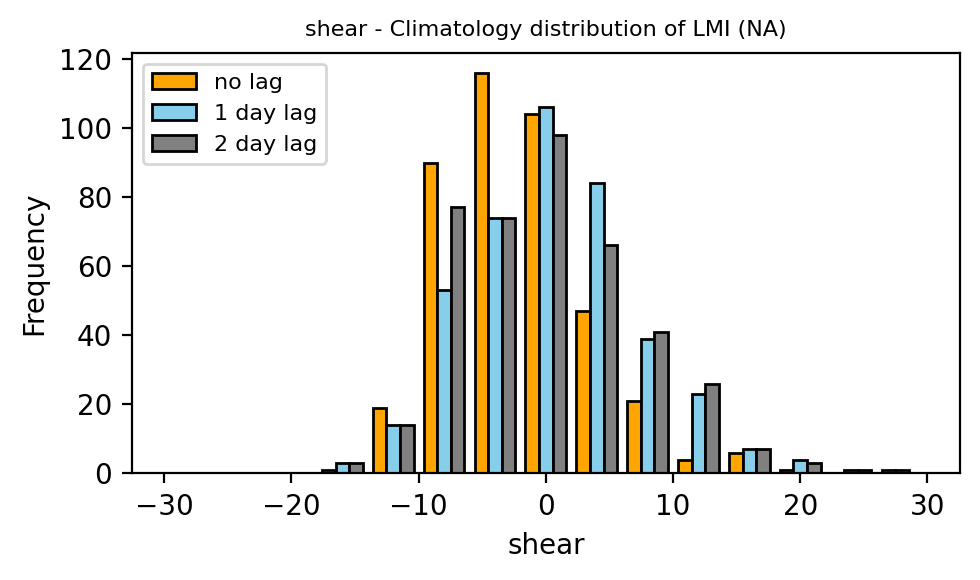

In [5]:
shear_cli = np.zeros((ntim))
 
for year in range(year_s, year_e + 1):
    flnm_nc = dir_o + 'global_lmi_e5_' + str(rr) + 'radius_shear_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_s:
            shear_cli_2d = ds.shear
        else:
            shear_cli_2d = shear_cli_2d + ds.shear
        
shear_cli_2d = shear_cli_2d/float(n_year)

for nt in range(ntim):
    shear_cli[nt] = shear_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean()


flnm_csv = [dir_o + 'global_lmi_e5_lag0d_0.5radius_shear_NA.csv',
            dir_o + 'global_lmi_e5_lag1d_0.5radius_shear_NA.csv',
            dir_o + 'global_lmi_e5_lag2d_0.5radius_shear_NA.csv']

bins = np.linspace(0, 30, 20)
hist_4(dir_plot, dir_o, 'shear', bins, flnm_csv, shear_cli)
bins = np.linspace(-30, 30, 16)
hist_3(dir_plot, dir_o, 'shear', bins, flnm_csv, shear_cli)
